# Sanitation Data

This notebook was loaded with:

```bash
PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS=notebook ./dse/bin/dse pyspark --num-executors 5 --driver-memory 6g --executor-memory 6g
```

The general plan is to do some exploration and cleaning in jupyter notebooks, then run our actual models by submitting python scripts and letting the jobs run as we'd expect.

We'll clean the data and load them into cassandra tables to be used by the jobs.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import isnull, count, datediff, lag, sum, coalesce, rank, lit, when,col, udf, to_date, year, mean, month, date_format, array
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType
from pyspark.ml.feature import StringIndexer
from datetime import datetime
from pyspark.sql.window import Window
import pyspark
import matplotlib
import matplotlib.pyplot as plt

We're going to work with this in pandas, too.

In [4]:
import pandas as pd
df_sanitation = pd.read_csv('data/311_Service_Requests_-_Sanitation_Code_Complaints.csv')

In [5]:
# Transform column headers to lower case
df_sanitation.columns = map(str.lower, df_sanitation.columns)

# Replace whitespace in headers
df_sanitation.columns = [x.strip().replace(' ', '_') for x in df_sanitation.columns]

In [10]:
df_sanitation = df_sanitation.drop('location', 1)

In [12]:
# Exclude NA's
df_sanitation = df_sanitation[~pd.isnull(df_sanitation['latitude'])]
# Exclude NA's
df_sanitation = df_sanitation[~pd.isnull(df_sanitation['longitude'])]

In [19]:
print "Shape of the data: ", df_sanitation.shape
print "Available data:\n", df_sanitation.columns

# View first few rows
df_sanitation.head()

Shape of the data:  (112597, 15)
Available data:
Index([u'creation_date', u'status', u'completion_date',
       u'service_request_number', u'type_of_service_request',
       u'what_is_the_nature_of_this_code_violation?', u'street_address',
       u'zip_code', u'x_coordinate', u'y_coordinate', u'ward',
       u'police_district', u'community_area', u'latitude', u'longitude'],
      dtype='object')


,creation_date,status,completion_date,service_request_number,type_of_service_request,what_is_the_nature_of_this_code_violation?,street_address,zip_code,x_coordinate,y_coordinate,ward,police_district,community_area,latitude,longitude
1,01/01/2011,Completed,01/03/2011,11-00001271,Sanitation Code Violation,Garbage in alley,3731 N KIMBALL AVE,60618.0,1.153055e+06,1.924737e+06,35.0,17.0,16.0,41.949330,-87.712791
2,01/01/2011,Completed,01/03/2011,11-00001278,Sanitation Code Violation,Garbage in yard,3036 N SAWYER AVE,60618.0,1.154187e+06,1.920017e+06,35.0,14.0,21.0,41.936356,-87.708757
3,01/01/2011,Completed,01/03/2011,11-00001696,Sanitation Code Violation,Construction Site Cleanliness/Fence,600 N CLARK ST,60654.0,1.175435e+06,1.904173e+06,42.0,18.0,8.0,41.892427,-87.631146
4,01/01/2011,Completed,01/03/2011,11-00002161,Sanitation Code Violation,Garbage in alley,10047 S FOREST AVE,60628.0,1.180021e+06,1.838415e+06,9.0,5.0,49.0,41.711877,-87.616318
5,01/01/2011,Completed,01/03/2011,11-00002373,Sanitation Code Violation,Garbage in yard,10648 S AVENUE B,60617.0,1.204784e+06,1.834964e+06,10.0,4.0,52.0,41.701807,-87.525750


In [20]:
#--------  Bar Plot
# A function to create a barplot
# Input: 
#      df (panda data frame)
#      var_name (name of the variable)
#      alpha (alpha value [0, 1])
#      title (title of the function)
#      color (color of the barplot)
#      edgecolor (cor of the outer barplotlines)
#      figsize (size of the figure)

def bar_plot(my_df, var_name, color='darkblue', alpha=0.6, title='', edgecolor='white', figsize=(18, 6)):
    
    ## Analyse crime types
    my_df['count'] = 1
    group = my_df.groupby(var_name)
    group = group.sum()
    group = group.sort_values('count', ascending=False)
    group = group['count']

    # Plot
    plt = group.plot(kind='bar', figsize=figsize, color=color, alpha=alpha, edgecolor=edgecolor, title=title)
    plt.grid()

In [21]:
#--------  Scatter Plot
# A function that visualizes the data
# Input: 
#      x (variable on the x-axis)
#      y (variable on the y_axis)
#      df (panda data frame)
#      group (grouping variable, i.e., variable to plot)
#      col (vector of colors)
#      alpha (alpha value for colors)
#      size (size of the dots)
#      title (title of the plot)
#      marker (shape of the marker, default to 'o')
#      add_line (add a line plot)
#      linewidth (thinkness of the added line)
#      figsize (size of the figure)

def scatter_plot(x, y, my_df, group, col, alpha, size, title, marker='o', add_line=False, linewidth=1, figsize=(15, 10)):
    
    # Define plot
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()

    # Extract unique categories
    cat = my_df[group].unique()

    # Loop trough categories
    for i in range(0, len(cat)) :
            ax.scatter(my_df[x][my_df[group] == cat[i]].values,
                       my_df[y][my_df[group] == cat[i]].values,
                       c=col[i], alpha=alpha, edgecolors="None", s=size,
                       label=cat[i],
                       marker=marker)
    # Add line plot
    if add_line:
            for i in range(0, len(cat)) :
                ax.plot(my_df[x][my_df[group] == cat[i]].values,
                           my_df[y][my_df[group] == cat[i]].values,
                           c=col[i], alpha=alpha, linewidth=linewidth)

    # Add legend, grid etc.
    ax.legend(loc=0, scatterpoints = 1) # Legend with just one dot
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.set_title(title)
    plt.grid()

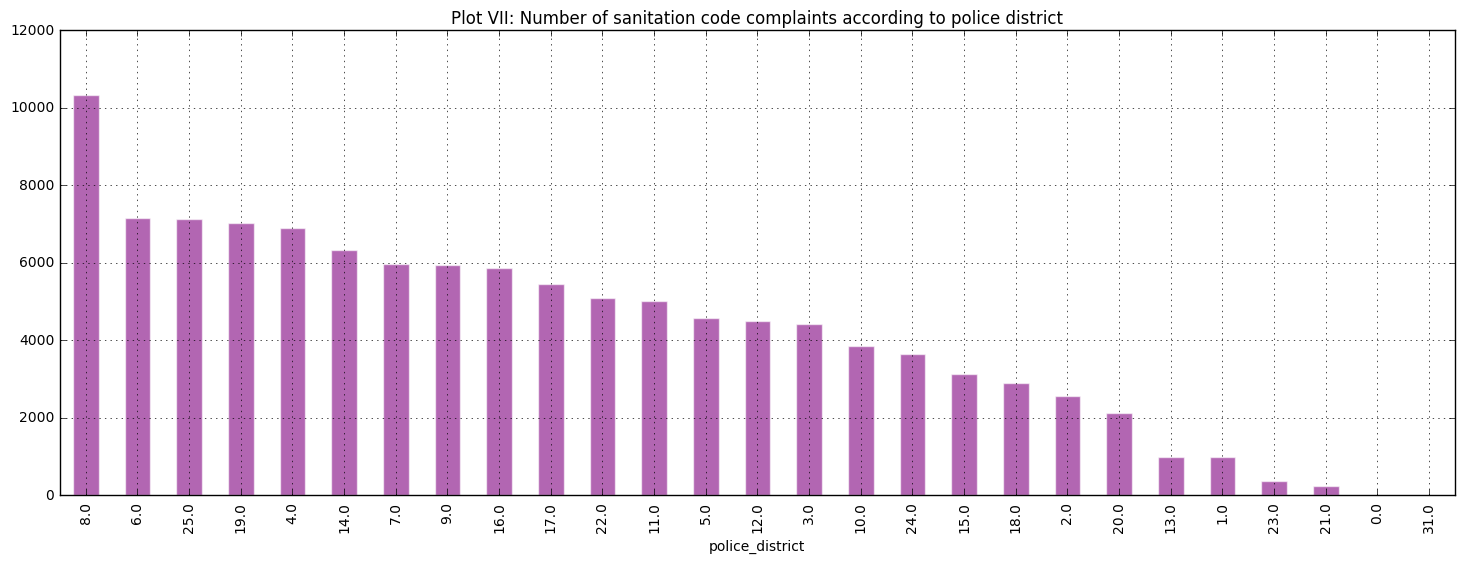

In [23]:
bar_plot(my_df=df_sanitation, var_name='police_district', color='purple', alpha=0.6,
         title='Plot VII: Number of sanitation code complaints according to police district', edgecolor='white', figsize=(18, 6))

Santitation complaints look similar to the crime stats.

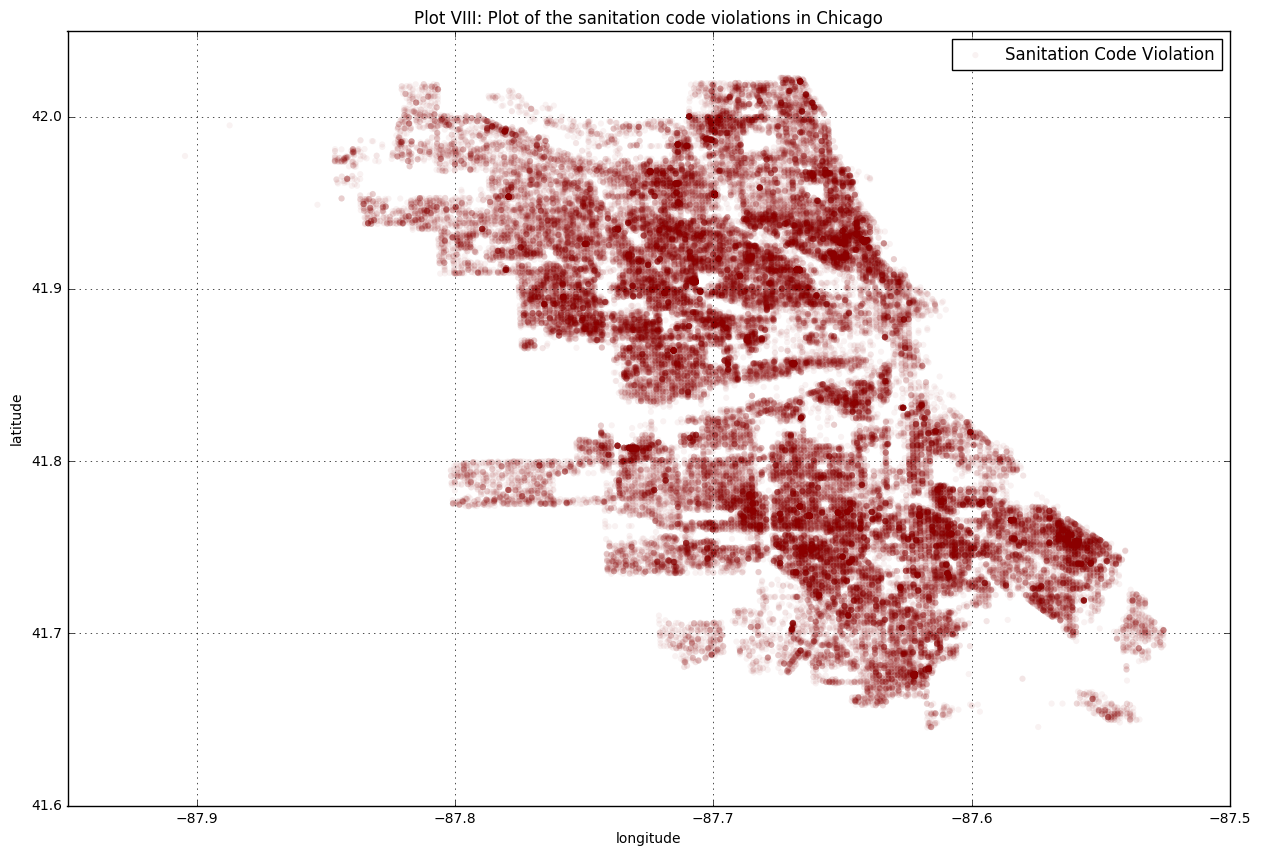

In [24]:
# Plot the data
col = ["darkred", "darkblue"]
scatter_plot(x='longitude', y='latitude', my_df=df_sanitation, group='type_of_service_request',
             col=col, alpha=0.05, size=20, marker='o',
             title="Plot VIII: Plot of the sanitation code violations in Chicago")

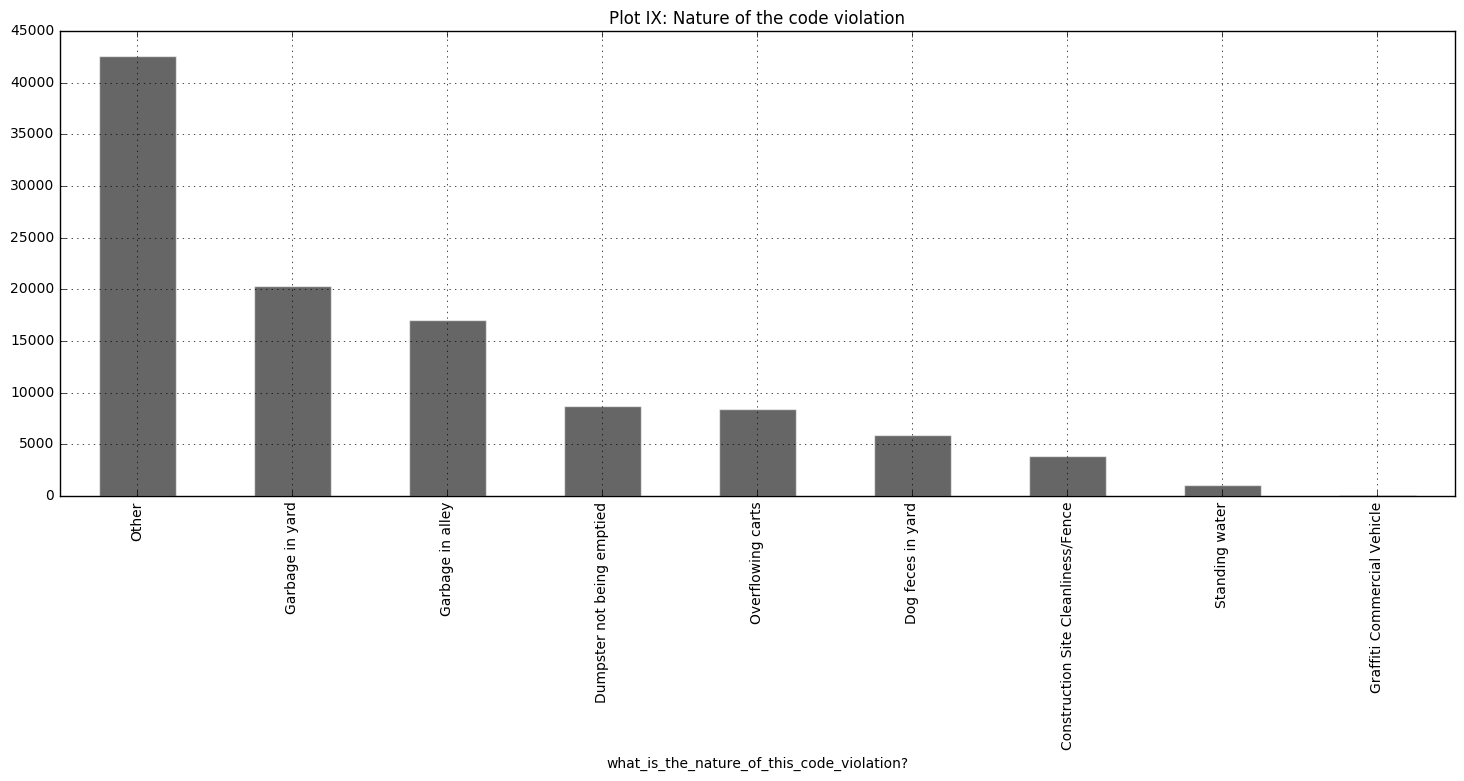

In [25]:
bar_plot(my_df=df_sanitation, var_name='what_is_the_nature_of_this_code_violation?', color='black', alpha=0.6,
         title='Plot IX: Nature of the code violation', edgecolor='white', figsize=(18, 6))


These are interesting to include in the model. Would certain types of santitation complaints be more influential in the predictive power of the food inspections model?

In [31]:
df_sanitation = df_sanitation.drop("count", 1)
df_sanitation = df_sanitation.drop("x_coordinate", 1)
df_sanitation = df_sanitation.drop("y_coordinate", 1)

df_sanitation.creation_date = df_sanitation.creation_date.astype(str)
df_sanitation.status = df_sanitation.status.astype(str)
df_sanitation.completion_date = df_sanitation.completion_date.astype(str)
df_sanitation.service_request_number = df_sanitation.service_request_number.astype(str)
df_sanitation['what_is_the_nature_of_this_code_violation?'] = df_sanitation['what_is_the_nature_of_this_code_violation?'].astype(str)
df_sanitation.street_address = df_sanitation.street_address.astype(str)

df_sanitation.dtypes

creation_date                                  object
status                                         object
completion_date                                object
service_request_number                         object
type_of_service_request                        object
what_is_the_nature_of_this_code_violation?     object
street_address                                 object
zip_code                                      float64
ward                                          float64
police_district                               float64
community_area                                float64
latitude                                      float64
longitude                                     float64
dtype: object

another interesting piece of data is the avg number of days between creation and completion of service request

In [34]:
df = sqlContext.createDataFrame(df_sanitation)

In [35]:
df.dtypes

[('creation_date', 'string'),
 ('status', 'string'),
 ('completion_date', 'string'),
 ('service_request_number', 'string'),
 ('type_of_service_request', 'string'),
 ('what_is_the_nature_of_this_code_violation?', 'string'),
 ('street_address', 'string'),
 ('zip_code', 'double'),
 ('ward', 'double'),
 ('police_district', 'double'),
 ('community_area', 'double'),
 ('latitude', 'double'),
 ('longitude', 'double')]

```cql
CREATE  KEYSPACE chicago_data 
   WITH REPLICATION = {'class' : 'SimpleStrategy', 'replication_factor' : 1};
```

```cql
CREATE TABLE chicago_data.sanitation (
    creation_date text,
    status text,
    completion_date text,
    service_request_number text,
    type_of_service_request text,
    "what_is_the_nature_of_this_code_violation?" text,
    street_address text,
    zip_code text,
    ward text,
    police_district double,
    community_area double,
    latitude double,
    longitude double,
    PRIMARY KEY (service_request_number));
```

In [37]:
 df.write\
    .format("org.apache.spark.sql.cassandra")\
    .mode('append')\
    .options(table="sanitation", keyspace="chicago_data")\
    .save()

In [36]:
df.count()

112597